In [1]:
import pandas as pd
import glob
import os
import json
#from kneed import KneeLocator
from sklearn.cluster import KMeans
#from tqdm import tqdm
#from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.cluster.elbow import kelbow_visualizer

# Hyperparameter

In [2]:
max_clusters = 30   #the maximum amount of subclusters, KMeans should generate for any man cluster
min_df = 0.05   #for tfidf vectorization: ignore terms that appear in less then min_df (percent) articles
max_df = 0.6    #for tfidf vectorization: ignore terms that appear in more than max_df (percent) articles
backup_cluster_amount = 10  #if the elbow point can not be calculated, this value will be chosen as the optimal amount of clusters


In [3]:
def cluster_data(df, i):
    processed_articles, amount_of_articles = count_articles(df)
    tfidf, words = convert_to_tfidf(processed_articles)
    model = calculate_kMeans(tfidf, i)
    cluster_words_list, df = gather_top_words(model, words, df)
    df = assign_top_words(cluster_words_list, df)
    df = date_month_publish(df)
    df = drop_unwanted_columns(df)
    create_cluster_files(df)
    return amount_of_articles

# Load JSON Files into Pandas Dataframe

Returns the preprocessed maintexts and count them. 

In [4]:
def count_articles(df):
    amount_of_articles = len(df["filtered_maintext"])
    processed_articles = df['filtered_maintext']
    return processed_articles, amount_of_articles

Convert the filtered maintexts to a TF-IDF-Vector

In [5]:
def convert_to_tfidf(processed_articles):
    tfidfconverter = TfidfVectorizer(lowercase=True, stop_words='english', min_df=min_df , max_df=max_df)  
    tfidf = tfidfconverter.fit_transform(processed_articles)
    words = tfidfconverter.get_feature_names()
    return tfidf, words

Create multiple KMeans models from the TF-IDF-Vector to find the best fitting clusters using the Elbow-method

In [6]:
def calculate_kMeans(tfidf, i):

    K = range(2,max_clusters)
    X = np.matrix(tfidf.toarray())
    
    print("Finding the best K-Means model (searching elbow)...")
    try:
        model = kelbow_visualizer(KMeans(max_iter=400), tfidf ,k=max_clusters)
        elbow = model.elbow_value_
        print("Found elbow for the following amount of clusters: " + str(elbow))

        print("Generating model with the optimal amount of clusters...")

        kMeans = KMeans(n_clusters=elbow, max_iter=400)
        kMeans.fit(tfidf)
        #kMeans.predict(tfidf)
        #kMeans.finalize()
        kMeans.show(outpath="./kelbow_minibatchkmeans.png")
        #kMeans.proof(outpath="./kelbow.png")
        
        return kMeans
    except:
        print("Could not find an elbow point. Continuing with the backup cluster amount.")
        elbow = backup_cluster_amount

        print("Generating model with the optimal amount of clusters...")

        kMeans = KMeans(n_clusters=elbow, max_iter=400).fit(tfidf)
        kMeans.predict(tfidf)
        return kMeans

Returns the top words foreach cluster

In [7]:
def gather_top_words(model, words, df):
    # save the clusterIDs to the dataframe
    # minus 2 because we start checking with 2 clusters
    df["kMeans_ID"] = model.labels_
    cluster_words_list = []
    common_words = model.cluster_centers_.argsort()[:,-1:-11:-1]
    for num, centroid in enumerate(common_words):
        cluster_words = []
        for word in centroid:
            cluster_words.append(words[word])
        cluster_words_list.append(cluster_words)

    return cluster_words_list, df

In [8]:
def assign_top_words(cluster_words_list, df):
    row_words = []
    for index, row in df.iterrows():
        cluster = row.kMeans_ID
        row_words.append(", ".join(cluster_words_list[cluster]))

    df['kMeans_topic_keywords'] = row_words  #join list of top words to a single string sorted by frequency
    return df


# Subcluster by release date

We will determine each articles release date and sort them into individual json files.

In [9]:
def getMonthYear(s):
     return s.split('-')[0]+"-"+s.split('-')[1]

# Generating folder structure

The following code creates the desired folder hierarchy and names each cluster after the top 3 dominant words in each one. Within each cluster/folder we are subclustering all articles by their release date.
The output json file has the format *year-month.json*. 

Returns the year and month for the division into different events

In [10]:
def date_month_publish(df):
    df['date_publish'] = pd.to_datetime(df['date_publish'])
    df['year_month'] = df['date_publish'].apply(lambda x: getMonthYear(str(x)))
    return df

generates the folder structure for the third level of clustering

In [11]:
def create_cluster_files(df):

    item_LDA = df.iloc[0]["LDA_topic_keywords"]  # the top words from the lda clustering
    item_LDA = item_LDA.split(", ") # make string a list
    cluster_id_LDA = df.iloc[0]["LDA_ID"]
    level1_directory = f'./clustered_json/cluster_{cluster_id_LDA}-{item_LDA[0]}_{item_LDA[1]}_{item_LDA[2]}'
    os.makedirs(level1_directory)   # create the directory for the LDa clustering level

    for cluster_id_kMeans, data in df.groupby(df.kMeans_ID):
        item_kMeans = data.iloc[0]["kMeans_topic_keywords"].split(", ")     # the top words from the kMeans clustering
        os.makedirs(f'{level1_directory}/cluster_{cluster_id_kMeans}-{item_kMeans[0]}_{item_kMeans[1]}_{item_kMeans[2]}_{item_kMeans[3]}_{item_kMeans[4]}')     #create the directory for the level 2 kMeans clustering
        for date, date_data in data.groupby(data.year_month):
            json_data = date_data.to_json(orient='records', force_ascii=False, date_format='iso', date_unit='s')
            parsed = json.loads(json_data)
            with open(f'{level1_directory}/cluster_{cluster_id_kMeans}-{item_kMeans[0]}_{item_kMeans[1]}_{item_kMeans[2]}_{item_kMeans[3]}_{item_kMeans[4]}/{date}.json', 'w', encoding='utf-8') as f:  #create the json file for the level 3 timed events
                f.write(json.dumps({"data": parsed}, indent=4, ensure_ascii=False))

In [12]:
def drop_unwanted_columns(df):
    df = df.drop(columns=["filtered_maintext"], errors='ignore')   #drop unwanted attributes that should not be output into the json files.\r\n"
    return df

Executing code for main cluster  lda_clustered_json\cluster_6-trump_ president_ obama.json
Finding the best K-Means model (searching elbow)...


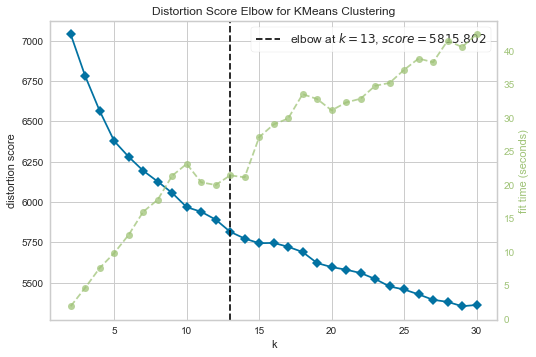

Found elbow for the following amount of clusters: 13
Generating model with the optimal amount of clusters...
Could not find an elbow point. Continuing with the backup cluster amount.
Generating model with the optimal amount of clusters...


In [13]:
path = 'lda_clustered_json/'    # the path of the folder where the lda clustered articles (level 1) are in

amount_of_articles = 0
i = 0
for filename in glob.glob(os.path.join(path, '*.json')):    #iterate through every json file in path
    print("Executing code for main cluster ", str(filename))
    with open(filename, encoding='utf-8', mode='r') as currentFile:
        df = pd.read_json(currentFile, orient='index')
        amount_of_articles = cluster_data(df, i)
    print("Finished multi level clustering of main cluster " + str(i) + ". Processed " + str(amount_of_articles) + " articles.")
    i = i+1